In [84]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, univariate_selection, RFE
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, RepeatedStratifiedKFold,\
StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

import pickle
import joblib

In [48]:
np.random.seed(2021)

In [141]:
df = pd.read_csv('ibm1.csv')
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102.0,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279.0,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373.0,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392.0,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591.0,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884.0,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613.0,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155.0,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023.0,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


In [142]:
df['Attrition']=pd.Series(np.where(df.Attrition.values == 'Yes', 1, 0))

In [143]:
df = df.drop(['EmployeeCount','StandardHours','Over18','EmployeeNumber'], axis=1).copy()
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102.0,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279.0,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373.0,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392.0,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591.0,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


# Pipeline

In [52]:
one_hot_cols=['BusinessTravel','Department','EducationField','Gender','JobRole','OverTime']

In [53]:
logit = LogisticRegression(random_state=2021)
smote = SMOTE()

In [144]:
logit_pipe_pca1 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=1))
])

logit_pipe_pca2 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

logit_pipe_num_im = Pipeline([
    ('imputer', SimpleImputer(strategy='mean', missing_values=np.nan)),
    ('scaler', StandardScaler())
])

logit_pipe_cat_im = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('onehot', OneHotEncoder(drop='first'))
])

logit_pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(drop='first')),
])

#transformer
logit_transformer = ColumnTransformer([
    ('pipe_num_im', logit_pipe_num_im, ['DailyRate', 'HourlyRate']),
    ('pipe_cat_im', logit_pipe_cat_im, ['MaritalStatus']),
    ('pipe_cat', logit_pipe_cat, one_hot_cols),
    ('pipe_pca1',logit_pipe_pca1,['MonthlyIncome','JobLevel']),
    ('pipe_pca2',logit_pipe_pca1,['YearsAtCompany','YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager'])
])

# combine all pipeline
logit_pipe_combine = Pipeline([
    ('transformer', logit_transformer),
    ('rfe', RFE(logit)),
    ('resampling', smote),
    ('logit', logit)
])

# Data Splitting

In [145]:
X = df.drop('Attrition', axis=1)
y = df['Attrition']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=2021) #check random_state

# Modelling Logistic Regression

In [147]:
skfold = StratifiedKFold(n_splits = 5, random_state=2021,shuffle=True)
logit_bench_cv = cross_val_score(logit_pipe_combine, X_train_val, y_train_val, cv = skfold, scoring='recall')

In [148]:
logit_bench_cv

array([0.73684211, 0.57894737, 0.71052632, 0.63157895, 0.73684211])

In [149]:
logit_bench_cv.mean()

0.6789473684210526

# Logit Benchmark

In [146]:
logit_pipe_combine

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('pipe_num_im',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DailyRate', 'HourlyRate']),
                                                 ('pipe_cat_im',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['MaritalStatus']

In [60]:
def make_confusion_matrix(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    conf_df = pd.DataFrame(
        {'p_0': [tn, fn, tn+fn], 'p_1': [fp, tp, fp+tp]}, index = ['a_0', 'a_1', 'total_prediction']
    )
    conf_df['total_actual'] = conf_df['p_0'] + conf_df['p_1']
    return conf_df

In [150]:
model_logit_default = logit_pipe_combine.fit(X_train_val, y_train_val)
y_pred_logit_default = model_logit_default.predict(X_test) 

In [151]:
print(classification_report(y_test, y_pred_logit_default))

              precision    recall  f1-score   support

           0       0.91      0.70      0.79       247
           1       0.29      0.66      0.41        47

    accuracy                           0.69       294
   macro avg       0.60      0.68      0.60       294
weighted avg       0.82      0.69      0.73       294



In [152]:
make_confusion_matrix(confusion_matrix(y_test, y_pred_logit_default))

,p_0,p_1,total_actual
a_0,172,75,247
a_1,16,31,47
total_prediction,188,106,294


# Logit Tuned

In [153]:
logit_params = {
    'logit__C': [100,10,1,0.1,0.01,0.001],
    'logit__solver': ['lbfgs', 'liblinear', 'newton-cg']
}

In [154]:
gridsearch = GridSearchCV(logit_pipe_combine, logit_params, scoring='recall', cv=skfold)
gridsearch.fit(X_train_val, y_train_val)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2021, shuffle=True),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('pipe_num_im',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['DailyRate',
                                                                          'HourlyRate']),
                                                                        ('pipe_cat_im',
                                                                         Pipeline(steps=[('imp

In [155]:
gridsearch.best_params_

{'logit__C': 0.001, 'logit__solver': 'liblinear'}

In [156]:
logit_tuned = gridsearch.best_estimator_
logit_tuned

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('pipe_num_im',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DailyRate', 'HourlyRate']),
                                                 ('pipe_cat_im',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['MaritalStatus']

In [157]:
model_logit_tuned=logit_tuned.fit(X_train_val, y_train_val)
y_pred_logit_tuned= model_logit_tuned.predict(X_test) 

In [158]:
print(classification_report(y_test, y_pred_logit_tuned))

              precision    recall  f1-score   support

           0       0.90      0.42      0.57       247
           1       0.20      0.77      0.32        47

    accuracy                           0.47       294
   macro avg       0.55      0.59      0.44       294
weighted avg       0.79      0.47      0.53       294



In [159]:
make_confusion_matrix(confusion_matrix(y_test, y_pred_logit_tuned))

,p_0,p_1,total_actual
a_0,103,144,247
a_1,11,36,47
total_prediction,114,180,294


# Precision Recall Curve

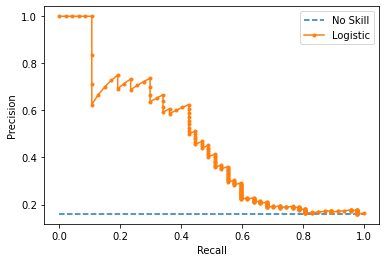

In [71]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
yhat = model_logit_tuned.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, treshold = precision_recall_curve(y_test, pos_probs)
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [72]:
pre_rec_data = {'precision': precision[:-1], 'recall': recall[:-1],'treshold':treshold}
pre_rec_df = pd.DataFrame(data=pre_rec_data)
pre_rec_df

,precision,recall,treshold
0,0.163194,1.000000,0.331738
1,0.160279,0.978723,0.344979
2,0.160839,0.978723,0.346588
3,0.161404,0.978723,0.351148
4,0.161972,0.978723,0.355435
...,...,...,...
283,1.000000,0.106383,0.589983
284,1.000000,0.085106,0.594815
285,1.000000,0.063830,0.602018
286,1.000000,0.042553,0.623619


In [73]:
pre_rec_df[(pre_rec_df['recall'].between(0.76, 0.78))].head(30)

,precision,recall,treshold
94,0.185567,0.765957,0.492599
95,0.186528,0.765957,0.493605
96,0.187500,0.765957,0.494497
97,0.188482,0.765957,0.494874
98,0.189474,0.765957,0.495084
99,0.190476,0.765957,0.495289
100,0.191489,0.765957,0.495821
101,0.192513,0.765957,0.496824


# Naive Bayes

In [160]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB() 

In [161]:
nb_pipe_pca1 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=1))
])

nb_pipe_pca2 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

nb_pipe_num_im = Pipeline([
    ('imputer', SimpleImputer(strategy='mean', missing_values=np.nan)),
    ('scaler', StandardScaler())
])

nb_pipe_cat_im = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('onehot', OneHotEncoder(drop='first'))
])

nb_pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(drop='first')),
])

#transformer
nb_transformer = ColumnTransformer([
    ('pipe_num_im', nb_pipe_num_im, ['DailyRate', 'HourlyRate']),
    ('pipe_cat_im', nb_pipe_cat_im, ['MaritalStatus']),
    ('pipe_cat', nb_pipe_cat, one_hot_cols),
    ('pipe_pca1',nb_pipe_pca1,['MonthlyIncome','JobLevel']),
    ('pipe_pca2',nb_pipe_pca1,['YearsAtCompany','YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager'])
])

#dtc
nb_pipe_combine = Pipeline([
    ('transformer', nb_transformer),
    ('resampling', smote),
    ('naive', gnb)
])

In [162]:
model_nb_default=nb_pipe_combine.fit(X_train_val, y_train_val)
y_pred_nb_default= model_nb_default.predict(X_test) 

In [163]:
print(classification_report(y_test, y_pred_nb_default))

              precision    recall  f1-score   support

           0       0.89      0.37      0.52       247
           1       0.19      0.77      0.30        47

    accuracy                           0.43       294
   macro avg       0.54      0.57      0.41       294
weighted avg       0.78      0.43      0.49       294



In [164]:
make_confusion_matrix(confusion_matrix(y_test, y_pred_nb_default))

,p_0,p_1,total_actual
a_0,91,156,247
a_1,11,36,47
total_prediction,102,192,294


# Precision Recall Curve GNB

In [79]:
from sklearn.metrics import classification_report, plot_confusion_matrix, precision_recall_curve, plot_precision_recall_curve, confusion_matrix

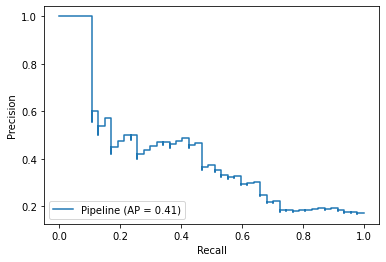

In [80]:
plot_precision_recall_curve(model_nb_default, X_test, y_test)

In [81]:
precision_gnb, recall_gnb, treshold_gnb = precision_recall_curve(y_test, pos_probs)

In [82]:
pre_rec_data_gnb = {'precision': precision_gnb[:-1], 'recall': recall_gnb[:-1],'treshold':treshold_gnb}
pre_rec_df_gnb = pd.DataFrame(data=pre_rec_data_gnb)
pre_rec_df_gnb

,precision,recall,treshold
0,0.163194,1.000000,0.331738
1,0.160279,0.978723,0.344979
2,0.160839,0.978723,0.346588
3,0.161404,0.978723,0.351148
4,0.161972,0.978723,0.355435
...,...,...,...
283,1.000000,0.106383,0.589983
284,1.000000,0.085106,0.594815
285,1.000000,0.063830,0.602018
286,1.000000,0.042553,0.623619


In [83]:
pre_rec_df_gnb[(pre_rec_df_gnb['recall'].between(0.78, 0.79))]

,precision,recall,treshold
80,0.177885,0.787234,0.480046
81,0.178744,0.787234,0.480587
82,0.179612,0.787234,0.483133
83,0.180488,0.787234,0.485561
84,0.181373,0.787234,0.485816
85,0.182266,0.787234,0.485915
86,0.183168,0.787234,0.486769
87,0.184080,0.787234,0.486947
88,0.185000,0.787234,0.487186
89,0.185930,0.787234,0.490731


# Model Saving

In [165]:
logit_final_saving=logit_tuned.fit(X,y)
filename = 'logit_final.sav'
pickle.dump(logit_final_saving, open(filename, 'wb'))

# Pickel Load

In [166]:
filename = 'logit_final.sav'
loaded_model = pickle.load((open(filename, 'rb')))

In [167]:
loaded_model

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('pipe_num_im',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DailyRate', 'HourlyRate']),
                                                 ('pipe_cat_im',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['MaritalStatus']

In [93]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [170]:
age = int(input('Umur?: '))
business_travel = input('Tingkat kepergian?: ')
daily_rate = int(input('Upah Harian?: '))
department = input('Departemen?: ')
distance_from_home=int(input('Jarak dari rumah?: '))
education=int(input('Tingkat pendidikan?: '))
education_field=input('Departemen pendidikan?: ')
environment_satisfaction=int(input('Tingkat kepuasan terhadap lingkungan?: '))
gender=input('Gender?:')
hourly_rate=int(input('Upah per-jam?: '))
job_involvement=int(input('Jumlah proyek?: '))
job_level=int(input('Pangkat pekerjaan?: '))
job_role=input('Divisi?: ')
job_satisfaction= int(input('Tingkat kepuasan terhadap pekerjaan?: '))
marital_status=input('Status hubungan?: ')
monthly_income=int(input('Gaji bulanan?: '))
monthly_rate=int(input('Upah bulanan?: '))
num_companies_worked=int(input('Jumlah perusahaan yang pernah ditempati?: '))
over_time=input('Sedang lembur?: ')
percent_salary_hike=int(input('Tingkat persentase kenaikan gaji?: '))
performance_rating=int(input('Performa pegawai?: '))
relationship_satisfaction=int(input('Tingkat kebahagiaan hubungan?: '))
stock_option_level=int(input('Tingkat kepemilihan opsi saham di perusahaan?: '))
total_working_years=int(input('Lama tahun bekerja?: '))
training_times_last_year=int(input('Lama tahun training?: '))
work_life_balance=int(input('Tingkatan work-life-balance?: '))
years_at_company=int(input('Lama tahun di perusahaan?: '))
years_in_current_role=int(input('Lama tahun di jabatan saat ini?: '))
years_since_last_promotion=int(input('Berapa tahuns sejak promosi terakhir?: '))
years_with_curr_manager=int(input('Lama tahun dengan manajer saat ini?: '))



#back-end
df_pickle = pd.DataFrame([[age, business_travel, daily_rate, department,distance_from_home,education,education_field,environment_satisfaction,gender,hourly_rate,job_involvement,job_level,job_role,job_satisfaction,marital_status,monthly_income,monthly_rate,num_companies_worked,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager]], columns=X_train_val.columns, index=[0])
class_label = loaded_model.predict(df_pickle)[0]
proba = loaded_model.predict_proba(df_pickle)

if class_label == 0:
    print('Bertahan')
else:
    print('Ada kemungkinan resign')
    
print(proba)

Umur?: 41
Tingkat kepergian?: Travel_Rarely
Upah Harian?: 1102
Departemen?: Sales
Jarak dari rumah?: 1
Tingkat pendidikan?: 2
Departemen pendidikan?: Other
Tingkat kepuasan terhadap lingkungan?: 2
Gender?:Male
Upah per-jam?: 94
Jumlah proyek?: 3
Pangkat pekerjaan?: 2
Divisi?: Sales Executive
Tingkat kepuasan terhadap pekerjaan?: 3
Status hubungan?: Single
Gaji bulanan?: 5993
Upah bulanan?: 19479
Jumlah perusahaan yang pernah ditempati?: 8
Sedang lembur?: Yes
Tingkat persentase kenaikan gaji?: 11
Performa pegawai?: 3
Tingkat kebahagiaan hubungan?: 2
Tingkat kepemilihan opsi saham di perusahaan?: 1
Lama tahun bekerja?: 6
Lama tahun training?: 2
Tingkatan work-life-balance?: 2
Lama tahun di perusahaan?: 6
Lama tahun di jabatan saat ini?: 4
Berapa tahuns sejak promosi terakhir?: 2
Lama tahun dengan manajer saat ini?: 5
Ada kemungkinan resign
[[0.44604238 0.55395762]]


In [168]:
X_train_val.columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [ ]:
df_pickle = pd.DataFrame([[age, business_travel, daily_rate, department,distance_from_home,education,education_field,environment_satisfaction,gender,hourly_rate,job_involvement,job_level,job_role,job_satisfaction,marital_status,monthly_income,monthly_rate,num_companies_worked,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager]], columns=X_train_val.columns, index=[0])
class_label = loaded_model.predict(df_pickle)[0]
proba = loaded_model.predict_proba(df_pickle)

In [106]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [110]:
df['Over18']

0       Y
1       Y
2       Y
3       Y
4       Y
       ..
1465    Y
1466    Y
1467    Y
1468    Y
1469    Y
Name: Over18, Length: 1470, dtype: object

In [173]:
df['MonthlyIncome'].mean()

6502.931292517007

In [ ]:
age = int(input('Umur?: '))
business_travel = input('Tingkat kepergian?: ')
daily_rate = int(input('Upah Harian?: '))
department = input('Departemen?: ')
distance_from_home=int(input('Jarak dari rumah?: '))
education=int(input('Tingkat pendidikan?: '))
education_field=input('Departemen pendidikan?: ')
environment_satisfaction=int(input('Tingkat kepuasan terhadap lingkungan?: '))
gender=input('Gender?:')
hourly_rate=int(input('Upah per-jam?: '))
job_involvement=int(input('Jumlah proyek?: '))
job_level=int(input('Pangkat pekerjaan?: '))
job_role=input('Divisi?: ')
job_satisfaction= int(input('Tingkat kepuasan terhadap pekerjaan?: '))
marital_status=input('Status hubungan?: ')
monthly_income=int(input('Gaji bulanan?: '))
monthly_rate=int(input('Upah bulanan?: '))
num_companies_worked=int(input('Jumlah perusahaan yang pernah ditempati?: '))
over_time=input('Sedang lembur?: ')
percent_salary_hike=int(input('Tingkat persentase kenaikan gaji?: '))
performance_rating=int(input('Performa pegawai?: '))
relationship_satisfaction=int(input('Tingkat kebahagiaan hubungan?: '))
stock_option_level=int(input('Tingkat kepemilihan opsi saham di perusahaan?: '))
total_working_years=int(input('Lama tahun bekerja?: '))
training_times_last_year=int(input('Lama tahun training?: '))
work_life_balance=int(input('Tingkatan work-life-balance?: '))
years_at_company=int(input('Lama tahun di perusahaan?: '))
years_in_current_role=int(input('Lama tahun di jabatan saat ini?: '))
years_since_last_promotion=int(input('Berapa tahuns sejak promosi terakhir?: '))
years_with_curr_manager=int(input('Lama tahun dengan manajer saat ini?: '))



#back-end
df_pickle = pd.DataFrame([[age, business_travel, daily_rate, department,distance_from_home,education,education_field,environment_satisfaction,gender,hourly_rate,job_involvement,job_level,job_role,job_satisfaction,marital_status,monthly_income,monthly_rate,num_companies_worked,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_since_last_promotion,years_with_curr_manager]], columns=X_train_val.columns, index=[0])
class_label = loaded_model.predict(df_pickle)[0]
proba = loaded_model.predict_proba(df_pickle)

if class_label == 0:
    print('Bertahan')
else:
    print('Ada kemungkinan resign')
    
print(proba)